In [1]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel
from setfit import SetFitTrainer
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import pipeline
from datasets import load_dataset
from transformers.pipelines.pt_utils import KeyDataset
import sklearn.metrics

/home/jc3642/anaconda3/envs/defects/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
df = pd.read_csv('./data_unlabeled/all_unlabeled.csv')
labeled_df = pd.read_csv('./data_labeled/all_labeled.csv')

unlabeled_set = Dataset.from_pandas(df)
labeled_test_set = Dataset.from_pandas(labeled_df)

In [4]:
# bug = labeled_df.loc[labeled_df['label'] == 0]
# docs = labeled_df.loc[labeled_df['label'] == 1].sample(50)
# feature = labeled_df.loc[labeled_df['label'] == 2].sample(50)
# question = labeled_df.loc[labeled_df['label'] == 3].sample(50)

bug_train, bug_test = train_test_split(labeled_df.loc[labeled_df['label'] == 0], random_state=seed, train_size=50, test_size=50)
docs_train, docs_test = train_test_split(labeled_df.loc[labeled_df['label'] == 1], random_state=seed, train_size=50, test_size=50)
feature_train, feature_test = train_test_split(labeled_df.loc[labeled_df['label'] == 2], random_state=seed, train_size=50, test_size=50)
question_train, question_test = train_test_split(labeled_df.loc[labeled_df['label'] == 3], random_state=seed, train_size=50)

train_df = pd.concat([bug_train, docs_train, feature_train, question_train], ignore_index=True)
test_df = pd.concat([bug_test, docs_test, feature_test, question_test], ignore_index=True)

train_set = Dataset.from_pandas(train_df)
test_set = Dataset.from_pandas(test_df)

## SETFIT Baseline Model from https://github.com/collab-uniba/Few-Shot-Learning-for-Issue-Report-Classification 

In [5]:
model = SetFitModel.from_pretrained("PeppoCola/FewShotIssueClassifier-NLBSE23")

/home/jc3642/anaconda3/envs/defects/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
y_pred = model.predict(test_set['text'])

print(classification_report(test_set['label'], y_pred, digits=4))
print(confusion_matrix(test_set['label'], y_pred))

              precision    recall  f1-score   support

         0.0     0.6364    0.5600    0.5957        50
         1.0     0.6491    0.7400    0.6916        50
         2.0     0.5849    0.6200    0.6019        50
         3.0     0.7200    0.6207    0.6667        29

    accuracy                         0.6369       179
   macro avg     0.6476    0.6352    0.6390       179
weighted avg     0.6391    0.6369    0.6357       179

[[28  8 11  3]
 [ 3 37  6  4]
 [ 7 12 31  0]
 [ 6  0  5 18]]


## Fine-tuned RoBERTa Baseline Model from https://github.com/nlbse2023/issue-report-classification  

In [7]:
classifier = pipeline(model="rafaelkallis/tickettagger-roberta", max_length=224, truncation=True, batch_size=256)

In [8]:
dataset = test_set

y_true = dataset["label"]
id2label = {0: "bug", 1: "documentation", 2: "feature", 3: "question"}
#id2label = {0: "bug", 1: "feature", 2: "question", 3: "documentation"}
y_true = [id2label[y] for y in y_true]

y_pred = list(tqdm(classifier(KeyDataset(dataset, "text")), total=len(y_true)))
y_pred = [p["label"] for p in y_pred]

for label in ["bug", "feature", "question", "documentation"]:
  P_c = sklearn.metrics.precision_score(y_true, y_pred, average=None, labels=[label])[0]
  R_c = sklearn.metrics.recall_score(y_true, y_pred, average=None, labels=[label])[0]
  F1_c = sklearn.metrics.f1_score(y_true, y_pred, average=None, labels=[label])[0]
  print(f"=*= {label} =*=")
  print(f"precision:\t{P_c:.4f}")
  print(f"recall:\t\t{R_c:.4f}")
  print(f"F1 score:\t{F1_c:.4f}")
  print()


P = sklearn.metrics.precision_score(y_true, y_pred, average='macro')
R = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
F1 = sklearn.metrics.f1_score(y_true, y_pred, average='micro')

print("=*= micro averages =*=")
print(f"precision:\t{P:.4f}")
print(f"recall:\t\t{R:.4f}")
print(f"F1 score:\t{F1:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:23<00:00,  7.61it/s]

=*= bug =*=
precision:	0.5067
recall:		0.7600
F1 score:	0.6080

=*= feature =*=
precision:	0.6545
recall:		0.7200
F1 score:	0.6857

=*= question =*=
precision:	1.0000
recall:		0.3793
F1 score:	0.5500

=*= documentation =*=
precision:	0.8947
recall:		0.6800
F1 score:	0.7727

=*= micro averages =*=
precision:	0.7640
recall:		0.6648
F1 score:	0.6648


## Train SETFIT Model from pre-labeled data 

In [9]:
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_set,
    eval_dataset=test_set,
    loss_class=CosineSimilarityLoss,
    num_iterations=20,
    num_epochs=1,
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [10]:
trainer.train()

Generating Training Pairs: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 41.97it/s]
***** Running training *****
  Num examples = 8000
  Num epochs = 1
  Total optimization steps = 500
  Total train batch size = 16
Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [2:42:10<00:00, 9730.06s/it]


Iteration:  57%|████████████████            | 287/500 [1:24:26<59:38, 16.80s/it]


Iteration:  77%|█████████████████████▌      | 384/500 [2:05:09<40:01, 20.70s/it]


Iteration:  96%|██████████████████████████▉ | 481/500 [2:34:45<05:35, 17.65s/it]


Epoch: 100%|██████████████████████████████████| 1/1 [2:40:02<00:00, 9602.10s/it]


In [11]:
metrics = trainer.evaluate()
metrics

***** Running evaluation *****


{'accuracy': 0.8156424581005587}

In [12]:
trainer.model._save_pretrained('model')

In [13]:
model = SetFitModel.from_pretrained('model')

In [14]:
y_pred = model.predict(test_set['text'])

print(classification_report(test_set['label'], y_pred, digits=4))
print(confusion_matrix(test_set['label'], y_pred))

              precision    recall  f1-score   support

         0.0     0.7959    0.7800    0.7879        50
         1.0     0.9149    0.8600    0.8866        50
         2.0     0.8077    0.8400    0.8235        50
         3.0     0.7097    0.7586    0.7333        29

    accuracy                         0.8156       179
   macro avg     0.8070    0.8097    0.8078       179
weighted avg     0.8185    0.8156    0.8166       179

[[39  1  4  6]
 [ 2 43  2  3]
 [ 5  3 42  0]
 [ 3  0  4 22]]


## Classify All Unlabeled Data 

In [15]:
y_pred = model.predict(unlabeled_set['text'])

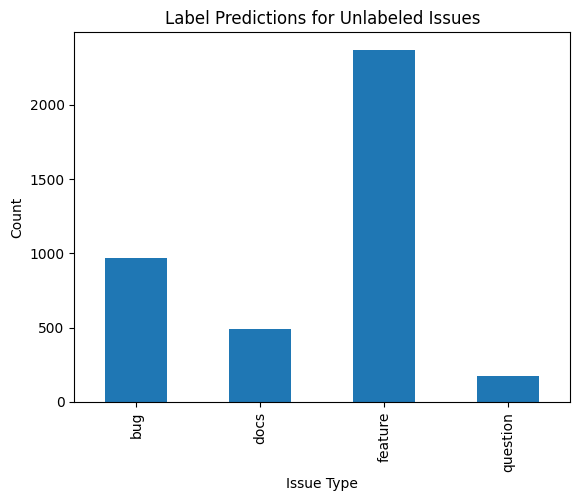

In [16]:
label_map = {
    0:'bug', 
    1:'docs',
    2:'feature',
    3:'question'
}

pred = pd.Categorical([label_map[x] for x in y_pred.numpy()])

#pred = pd.DataFrame(y_pred.numpy())

pred.value_counts().plot(kind='bar')
plt.title('Label Predictions for Unlabeled Issues')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.show()

In [17]:
df['preds'] = pred

df.to_csv('preds.csv')